##Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import nltk
import re
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [41]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import  DecisionTreeClassifier

##Load Data

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/SMSSpamCollection', sep = "\t", names = ['labels', 'message'])

###Knowing more about Data

In [6]:
df

,labels,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   labels   5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [8]:
df.describe()

,labels,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [9]:
df.shape

(5572, 2)

In [10]:
df.isnull().sum()

labels     0
message    0
dtype: int64

In [11]:
df['labels']=df['labels'].map({'ham':0, 'spam':1})
df

,labels,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


##EDA: Exploratory Data Analysis

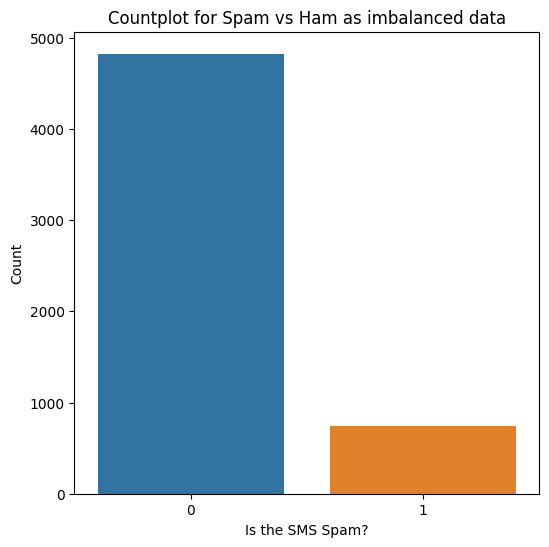

In [12]:
#Countplot for spam vs ham for imbalanced dataset
plt.figure(figsize = (6, 6))
p = sns.countplot(x = 'labels', data = df)
p = plt.title('Countplot for Spam vs Ham as imbalanced data')
p = plt.xlabel('Is the SMS Spam?')
p = plt.ylabel('Count')

In [13]:
#checking for only_spam texts
only_spam = df[df['labels'] == 1]
only_spam

,labels,message
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
5,1,FreeMsg Hey there darling it's been 3 week's n...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...
11,1,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [14]:
count = int((df.shape[0] - only_spam.shape[0]) / only_spam.shape[0])
count

6

In [15]:
for i in range (0, count - 1):
  df = pd.concat([df, only_spam])

In [16]:
df.reset_index()

,index,labels,message
0,0,0,"Go until jurong point, crazy.. Available only ..."
1,1,0,Ok lar... Joking wif u oni...
2,2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,3,0,U dun say so early hor... U c already then say...
4,4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...,...
9302,5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
9303,5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
9304,5547,1,Had your contract mobile 11 Mnths? Latest Moto...
9305,5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [17]:
# Calculate word count for each message and add it as a new column 'word_count'
df['word_count'] = df['message'].apply(lambda x: len(x.split()))

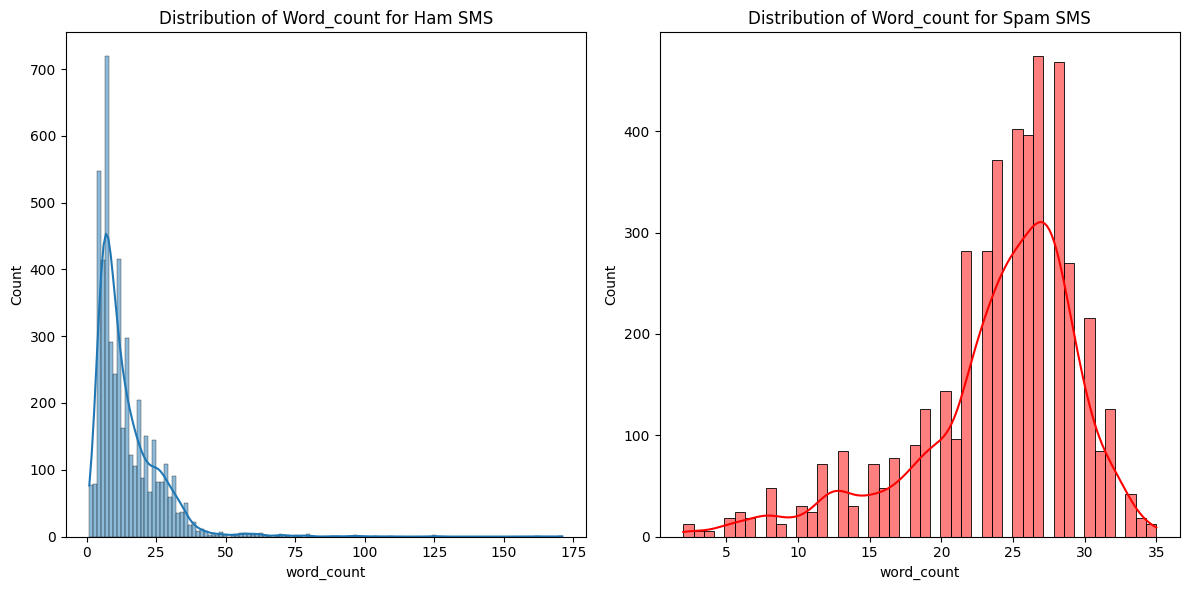

In [18]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
g = sns.histplot(df[df['labels'] == 0].word_count, kde = True)
p = plt.title('Distribution of Word_count for Ham SMS')

plt.subplot(1, 2, 2)
g = sns.histplot(df[df['labels'] == 1].word_count, kde = True, color = 'red')
p = plt.title('Distribution of Word_count for Spam SMS')

plt.tight_layout()
plt.show()

In [19]:
def currency(data):
  currency_symbols = ['$', '£', '€', '¥', '₹' ]
  for i in currency_symbols:
    if i in data:
      return 1
    return 0

In [20]:
df['contains_currency_symbol'] = df['message'].apply(currency)

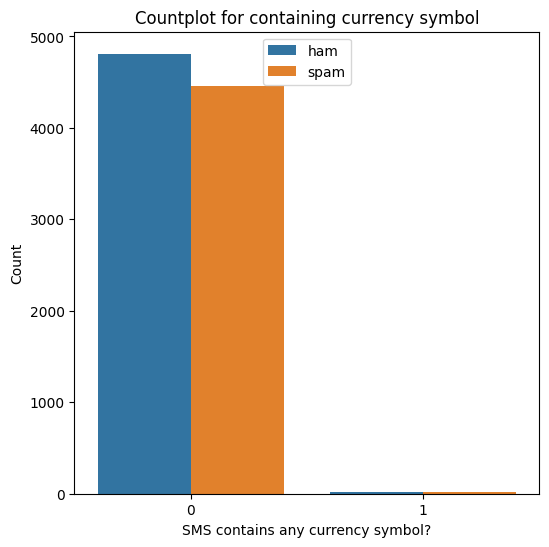

In [21]:
plt.figure(figsize = (6, 6))
p = sns.countplot(x = 'contains_currency_symbol', data = df, hue = 'labels')
p = plt.title('Countplot for containing currency symbol')
p = plt.xlabel('SMS contains any currency symbol?')
p = plt.ylabel('Count')
p = plt.legend(labels = ["ham", "spam"], loc = 9)

In [22]:
def number(data):
  for i in data:
    if ord(i) >= 48 and ord(i) <= 57:
        return 1
  return 0

In [23]:
df["contains_number"] = df["message"].apply(number)

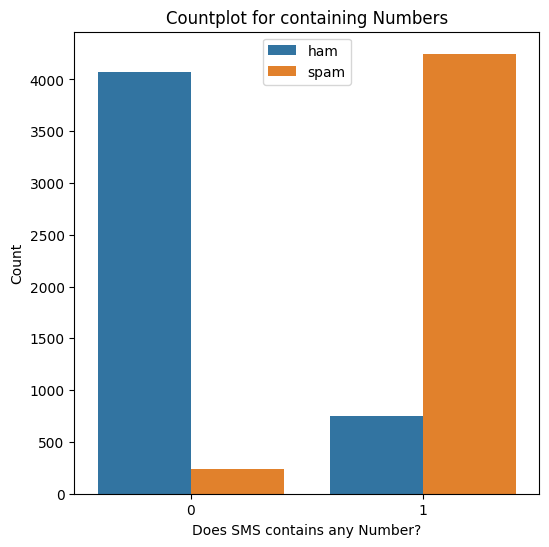

In [24]:
plt.figure(figsize = (6, 6))
p = sns.countplot(x = 'contains_number', data = df, hue = 'labels')
p = plt.title('Countplot for containing Numbers')
p = plt.xlabel('Does SMS contains any Number?')
p = plt.ylabel('Count')
p = plt.legend(labels = ["ham", "spam"], loc = 9)

##Data Cleaning

In [25]:
corpus = []
wnl = WordNetLemmatizer()

for sms in list(df.message):
  message = re.sub(pattern = '[^a-zA-Z]', repl = ' ', string = sms )   #filling out special characters
  message = message.lower()
  words = message.split() #tokenizer
  filtered_words = [word for word in words if word not in set (stopwords.words('english'))]
  lemm_words = [wnl.lemmatize(word) for word in filtered_words]
  message = ' '.join(lemm_words)

  corpus.append(message)

In [26]:
corpus

['go jurong point crazy available bugis n great world la e buffet cine got amore wat',
 'ok lar joking wif u oni',
 'free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply',
 'u dun say early hor u c already say',
 'nah think go usf life around though',
 'freemsg hey darling week word back like fun still tb ok xxx std chgs send rcv',
 'even brother like speak treat like aid patent',
 'per request melle melle oru minnaminunginte nurungu vettam set callertune caller press copy friend callertune',
 'winner valued network customer selected receivea prize reward claim call claim code kl valid hour',
 'mobile month u r entitled update latest colour mobile camera free call mobile update co free',
 'gonna home soon want talk stuff anymore tonight k cried enough today',
 'six chance win cash pound txt csh send cost p day day tsandcs apply reply hl info',
 'urgent week free membership prize jackpot txt word claim c www dbuk net lccltd pobox ldnw rw'

In [27]:
#creating a bag of words
tfidf = TfidfVectorizer(max_features = 500)
vectors = tfidf.fit_transform(corpus).toarray()
feature_names = tfidf.get_feature_names_out()

In [28]:
X = pd.DataFrame(vectors, columns = feature_names)
y = df['labels']

In [29]:
X

,ac,access,account,address,admirer,age,already,also,always,amp,...,xxx,ya,yeah,year,yes,yesterday,yet,yo,yr,yup
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.4117,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9302,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
9303,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.326017,0.0,0.0,0.0,0.0,0.0
9304,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.287064,0.0,0.0,0.0,0.0,0.0
9305,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [30]:
y

0       0
1       0
2       1
3       0
4       0
       ..
5537    1
5540    1
5547    1
5566    1
5567    1
Name: labels, Length: 9307, dtype: int64

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [32]:
X_train

,ac,access,account,address,admirer,age,already,also,always,amp,...,xxx,ya,yeah,year,yes,yesterday,yet,yo,yr,yup
3533,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2592,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4253,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.343368,0.0,0.0,0.0,0.0,0.0,0.0
6976,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7191,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5191,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5390,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
860,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


##Model

In [33]:
#Naive Bayes Model
mnb = MultinomialNB()
cv = cross_val_score(mnb, X, y, scoring = 'f1', cv = 10)
print(round(cv.mean(), 3))
print(round(cv.std(), 3))

0.943
0.004


In [34]:
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)

In [35]:
y_pred

array([0, 0, 0, ..., 0, 1, 0])

In [36]:
y_test

1155    0
1790    0
3003    0
1122    1
592     1
       ..
4147    0
274     0
1345    0
2367    1
4031    0
Name: labels, Length: 1862, dtype: int64

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       959
           1       0.94      0.94      0.94       903

    accuracy                           0.94      1862
   macro avg       0.94      0.94      0.94      1862
weighted avg       0.94      0.94      0.94      1862



In [38]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[905,  54],
       [ 56, 847]])

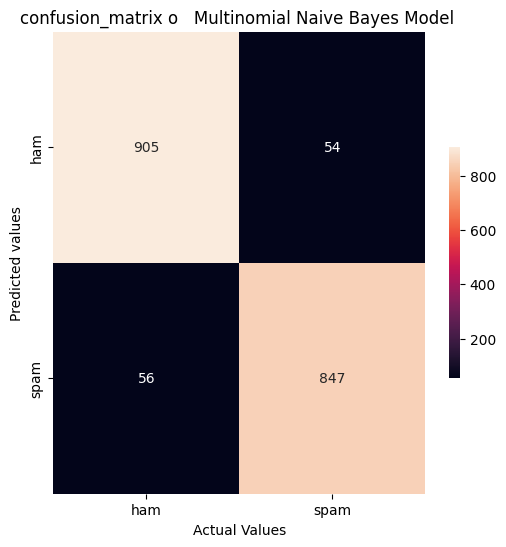

In [39]:
plt.figure(figsize = (6, 6))
axis_labels = ['ham', 'spam']
g = sns.heatmap(data = cm, xticklabels = axis_labels, yticklabels = axis_labels, annot = True, fmt = 'g', cbar_kws = {"shrink":0.5})
p = plt.title("confusion_matrix o   Multinomial Naive Bayes Model ")
p = plt.xlabel('Actual Values')
p =plt.ylabel('Predicted values')

In [42]:
dt = DecisionTreeClassifier()
cv1 = cross_val_score(dt, X, y, scoring='f1', cv=10)
print(round(cv1.mean(), 3))
print(round(cv1.std(), 3))

0.981
0.004


In [43]:
dt.fit(X_train, y_train)
y_pred1 = dt.predict(X_test)

In [44]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       959
           1       0.97      1.00      0.98       903

    accuracy                           0.98      1862
   macro avg       0.98      0.98      0.98      1862
weighted avg       0.98      0.98      0.98      1862



In [45]:
cm = confusion_matrix(y_test, y_pred1)
cm

array([[934,  25],
       [  4, 899]])

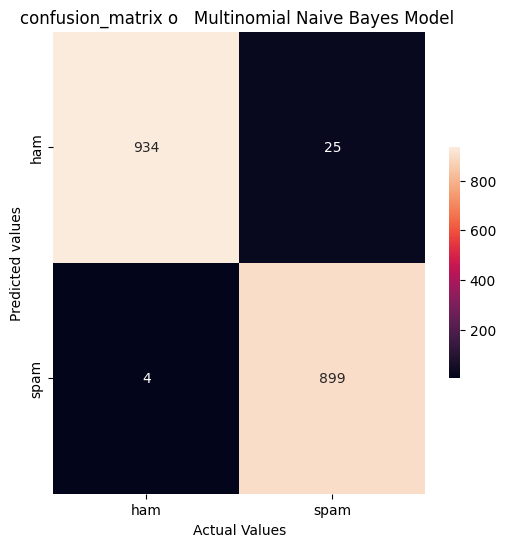

In [46]:
plt.figure(figsize = (6, 6))
axis_labels = ['ham', 'spam']
g = sns.heatmap(data = cm, xticklabels = axis_labels, yticklabels = axis_labels, annot = True, fmt = 'g', cbar_kws = {"shrink":0.5})
p = plt.title("confusion_matrix o   Multinomial Naive Bayes Model ")
p = plt.xlabel('Actual Values')
p =plt.ylabel('Predicted values')

In [47]:
def predict_spams(sms):
  message = re.sub(pattern= '[^a-zA-Z]', repl = ' ', string = sms)
  message = message.lower()
  words = message.split() #tokenizer
  filtered_words = [word for word in words if word not in set (stopwords.words('english'))]
  lemm_words = [wnl.lemmatize(word) for word in filtered_words]
  message = ' '.join(lemm_words)
  temp = tfidf.transform([message]).toarray()
  return dt.predict(temp)

In [48]:
#Prediction1 - lottery text message
sample_message = 'Important - You could be entitled up tpo $3,160 in compensation from mis-sold PPI for info or STOP to opt out'

if predict_spams(sample_message):
  print('Gotcha! This is a SPAM message')

else:
  print('This is a HAM (normal) message')

Gotcha! This is a SPAM message


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
